# Herschel Stripe 82 master catalogue
## Preparation of Hyper Suprime-Cam Subaru Strategic Program Catalogues (HSC-SSP) data

This catalogue comes from `dmu0_HSC`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The g, r, i, z, y, N816, N921 aperture magnitude (for now in 3”);
- The g, r, i, z, y, N816, N921 kron fluxes and magnitudes.

**TODO**: Check that the aperture magnitudes are aperture corrected and that all the magnitudes are AB.

**TODO**: Check for stellarity.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
79293bd (Wed Jun 21 16:47:54 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/research/astro/fir/HELP/help_python/miniconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "hsc_ra"
DEC_COL = "hsc_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "object_id": "hsc_id",
        "ra": "hsc_ra",
        "dec": "hsc_dec",
        "gmag_aperture30": "m_app_suprime_g",
        "gmag_aperture30_err": "merr_app_suprime_g",
        "gmag_kron": "m_suprime_g",
        "gmag_kron_err": "merr_suprime_g",
        "rmag_aperture30": "m_app_suprime_r",
        "rmag_aperture30_err": "merr_app_suprime_r",
        "rmag_kron": "m_suprime_r",
        "rmag_kron_err": "merr_suprime_r",
        "imag_aperture30": "m_app_suprime_i",
        "imag_aperture30_err": "merr_app_suprime_i",
        "imag_kron": "m_suprime_i",
        "imag_kron_err": "merr_suprime_i",
        "zmag_aperture30": "m_app_suprime_z",
        "zmag_aperture30_err": "merr_app_suprime_z",
        "zmag_kron": "m_suprime_z",
        "zmag_kron_err": "merr_suprime_z",
        "ymag_aperture30": "m_app_suprime_y",
        "ymag_aperture30_err": "merr_app_suprime_y",
        "ymag_kron": "m_suprime_y",
        "ymag_kron_err": "merr_suprime_y",
        "n816mag_aperture30": "m_app_suprime_n816",
        "n816mag_aperture30_err": "merr_app_suprime_n816",
        "n816mag_kron": "m_suprime_n816",
        "n816mag_kron_err": "merr_suprime_n816",
        "n921mag_aperture30": "m_app_suprime_n921",
        "n921mag_aperture30_err": "merr_app_suprime_n921",
        "n921mag_kron": "m_suprime_n921",
        "n921mag_kron_err": "merr_suprime_n921",
    })


catalogue = Table.read("../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_ELAIS-N1.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'app' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,hsc_id,hsc_ra,hsc_dec,m_app_suprime_g,merr_app_suprime_g,m_suprime_g,merr_suprime_g,m_app_suprime_r,merr_app_suprime_r,m_suprime_r,merr_suprime_r,m_app_suprime_i,merr_app_suprime_i,m_suprime_i,merr_suprime_i,m_app_suprime_z,merr_app_suprime_z,m_suprime_z,merr_suprime_z,m_app_suprime_y,merr_app_suprime_y,m_suprime_y,merr_suprime_y,m_app_suprime_n816,merr_app_suprime_n816,m_suprime_n816,merr_suprime_n816,m_app_suprime_n921,merr_app_suprime_n921,m_suprime_n921,merr_suprime_n921,f_app_suprime_g,ferr_app_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_app_suprime_r,ferr_app_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_app_suprime_i,ferr_app_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_app_suprime_z,ferr_app_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_app_suprime_y,ferr_app_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,f_app_suprime_n816,ferr_app_suprime_n816,f_suprime_n816,ferr_suprime_n816,flag_suprime_n816,f_app_suprime_n921,ferr_app_suprime_n921,f_suprime_n921,ferr_suprime_n921,flag_suprime_n921
0,74696447714394117,242.747025587,53.1797298364,22.31,0.00882253,22.4025,0.00613778,21.4512,0.0106623,21.536,0.00721748,21.0242,0.00933809,21.0396,0.00606723,20.8335,0.0139513,20.9075,0.00958001,20.88,0.0347368,20.8242,0.0207586,nan,nan,nan,nan,20.8579,0.0163495,20.9343,0.0110321,4.32501,0.0351444,3.97195,0.0224539,False,9.53915,0.0936779,8.8229,0.0586506,False,14.1359,0.121578,13.9371,0.0778825,False,16.8505,0.216523,15.7401,0.138883,False,16.1437,0.516498,16.9956,0.324944,False,nan,nan,nan,nan,False,16.475,0.248087,15.3567,0.156038,False
1,74696447714394122,242.719348976,53.1801111556,25.6909,0.17614,25.8527,0.181234,26.1001,0.738448,26.0693,0.631967,24.556,0.234527,24.9409,0.297491,24.7801,0.509907,24.5777,0.384445,nan,nan,nan,nan,nan,nan,nan,nan,24.1197,0.327259,24.177,0.308791,0.192142,0.0311714,0.165547,0.0276335,False,0.131813,0.0896505,0.13561,0.0789337,False,0.546533,0.118055,0.383372,0.105044,False,0.444609,0.208807,0.535678,0.189676,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,0.816791,0.246195,0.77485,0.220373,False
2,74696447714394124,242.762756137,53.1799997889,25.0237,0.120359,25.093,0.0908099,24.3207,0.142652,24.4715,0.112476,24.0065,0.14197,24.0649,0.103878,23.4653,0.274363,23.7749,0.257284,23.1594,0.294667,23.2305,0.229978,nan,nan,nan,nan,23.4372,0.169566,23.5994,0.141649,0.355235,0.0393794,0.333259,0.0278734,False,0.678763,0.089181,0.590726,0.0611957,False,0.906572,0.118542,0.859105,0.0821947,False,1.49235,0.377113,1.1221,0.265902,False,1.97812,0.536857,1.85273,0.392441,False,nan,nan,nan,nan,False,1.53149,0.239182,1.31901,0.172082,False
3,74696447714394125,242.80348378,53.1796174143,25.3829,0.130357,25.2032,0.0912907,25.0386,0.278055,24.9213,0.204127,26.1074,0.99016,25.7927,0.609404,nan,nan,nan,nan,nan,nan,26.1567,3.80569,nan,nan,nan,nan,nan,nan,25.1451,0.690551,0.255177,0.0306375,0.301101,0.0253171,False,0.350394,0.0897353,0.390374,0.0733934,False,0.130928,0.119403,0.174959,0.0982013,False,nan,nan,nan,nan,False,nan,nan,0.125121,0.43857,False,nan,nan,nan,nan,False,nan,nan,0.317652,0.202033,False
4,74696447714394127,242.708654667,53.1806525116,23.4638,0.0231806,23.3749,0.0250742,22.6475,0.0310366,22.5793,0.0342899,22.3041,0.0289278,22.2092,0.0313284,22.1996,0.0470352,22.0771,0.0508749,21.664,0.0732299,21.5661,0.0805458,nan,nan,nan,nan,22.1945,0.0547012,22.1227,0.0607051,1.49438,0.0319051,1.62201,0.0374592,False,3.16956,0.0906042,3.37511,0.106593,False,4.34881,0.115868,4.74587,0.13694,False,4.78786,0.207415,5.36018,0.251165,False,7.84134,0.528876,8.58135,0.636611,False,nan,nan,nan,nan,False,4.81062,0.242367,5.13946,0.287355,False
5,74696447714394132,242.771208012,53.1802711714,23.9952,0.0445013,24.0478,0.0326,23.2263,0.0528499,23.3486,0.0396932,22.9691,0.0540773,22.9498,0.0360883,22.5591,0.118987,22.7962,0.0991147,22.7596,0.197404,22.9694,0.161597,nan,nan,nan,nan,22.9812,0.113452,23.0168,0.0777004,0.916069,0.0375471,0.872759,0.0262052,False,1.8598,0.0905288,1.66171,0.06075

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = [
        'merr_app_suprime_i', 'merr_app_suprime_r', 'merr_app_suprime_z',
        'merr_app_suprime_y', 'merr_app_suprime_g']
FLAG_NAME = 'hsc_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/research/astro/fir/HELP/help_python/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 2733395 sources.
The cleaned catalogue has 2733236 sources (159 removed).
The cleaned catalogue has 154 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-N1.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

/research/astro/fir/HELP/help_python/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


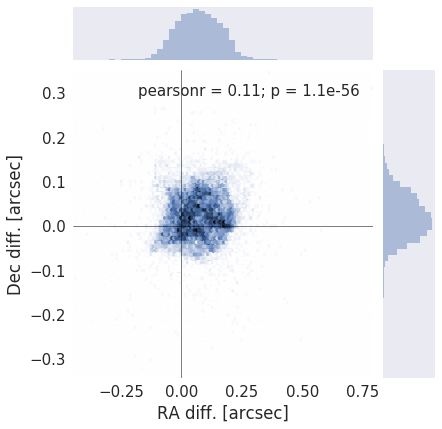

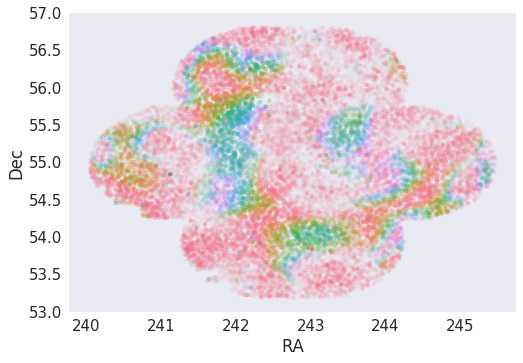

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.06906133751272137 arcsec
Dec correction: -0.018244228975561327 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

/research/astro/fir/HELP/help_python/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


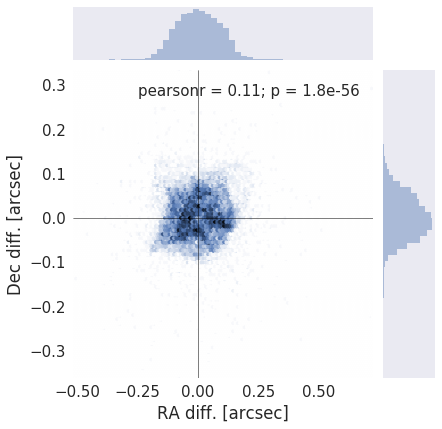

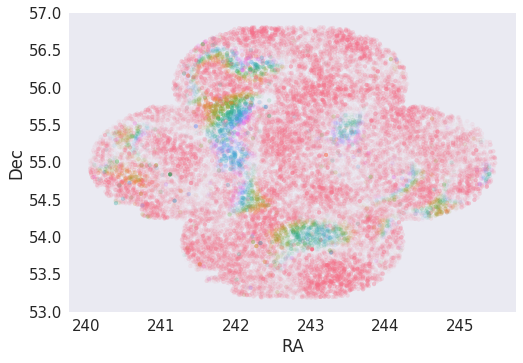

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "hsc_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

20343 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/HSC-SSP.fits".format(OUT_DIR), overwrite=True)